<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/DmitryGribkov-folder/Selector_Final_codes_20230625.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From: https://drive.google.com/uc?id=1ZdQ1dAGWOL8lTK73MQV1UQf-2S8BKcTq
To: /content/processed_extended_dataset.zip
100%|██████████| 76.6M/76.6M [00:00<00:00, 124MB/s]


Epoch 1/10
165/165 [==============================] - 81s 479ms/step - loss: 0.0448 - val_loss: 0.0192
Epoch 2/10
165/165 [==============================] - 79s 479ms/step - loss: 0.0169 - val_loss: 0.0141
Epoch 3/10
165/165 [==============================] - 78s 473ms/step - loss: 0.0134 - val_loss: 0.0120
Epoch 4/10
165/165 [==============================] - 79s 477ms/step - loss: 0.0106 - val_loss: 0.0090
Epoch 5/10
165/165 [==============================] - 78s 475ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 6/10
165/165 [==============================] - 79s 477ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 7/10
165/165 [==============================] - 79s 477ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 8/10
165/165 [==============================] - 83s 504ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 9/10
165/165 [==============================] - 78s 474ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 10/10
412/412 [==============================] - 11s 27ms/step


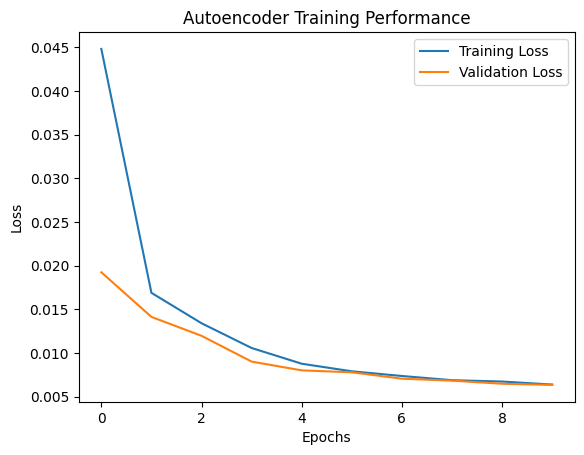

83/83 [==============================] - 5s 60ms/step
Training Reconstruction Error: 3.97%
Test Reconstruction Error: 4.04%


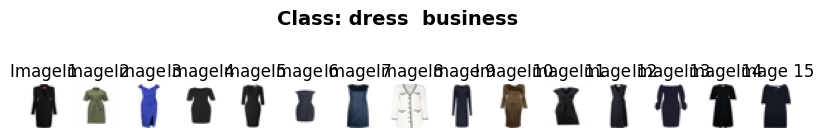

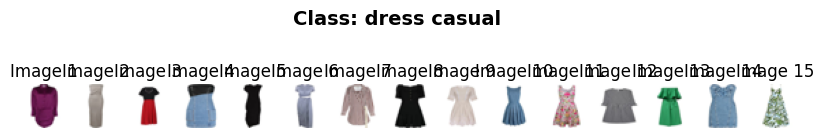

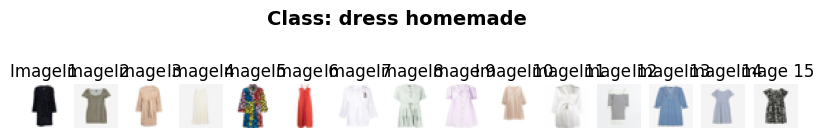

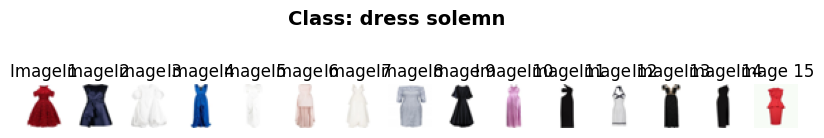

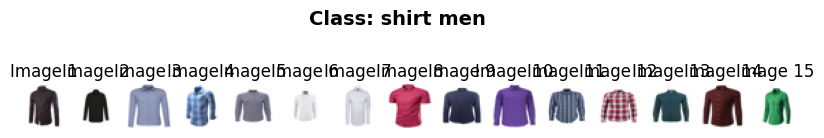

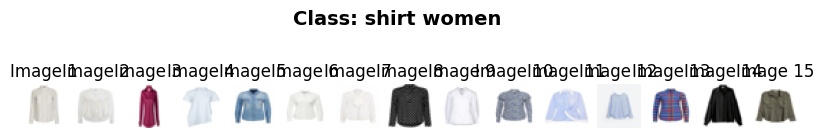

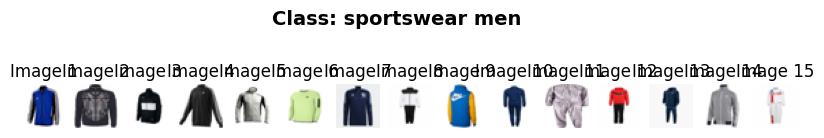

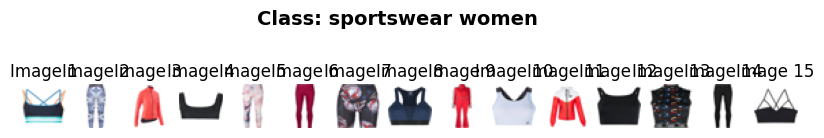

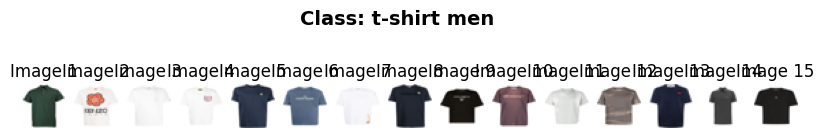

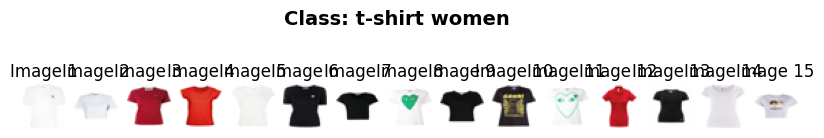

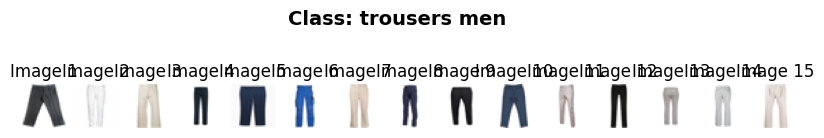

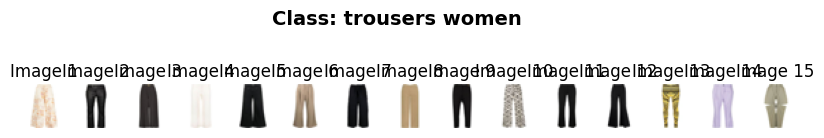

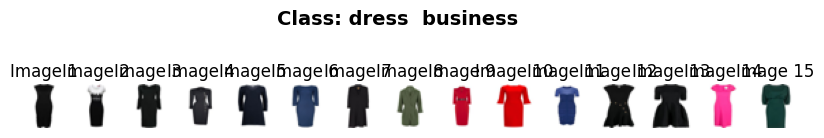

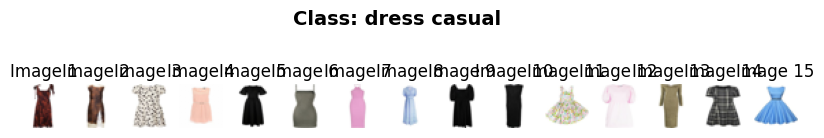

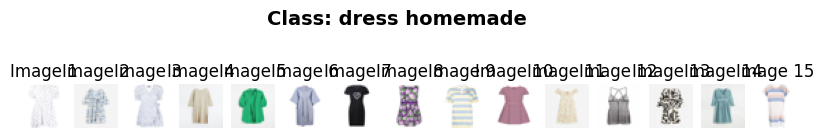

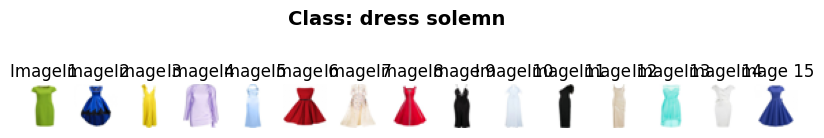

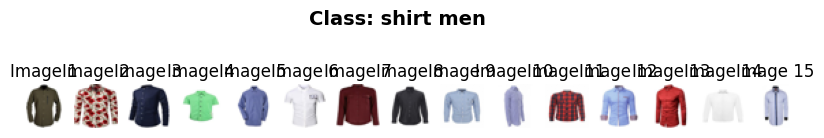

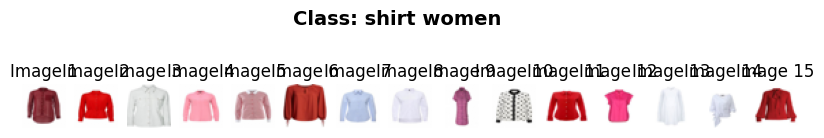

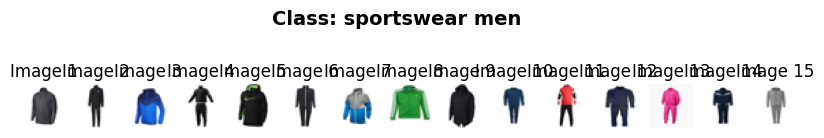

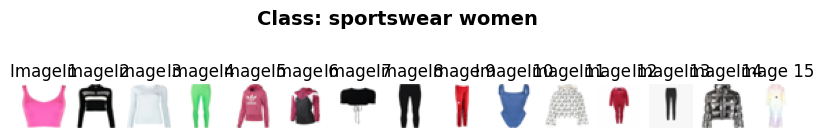

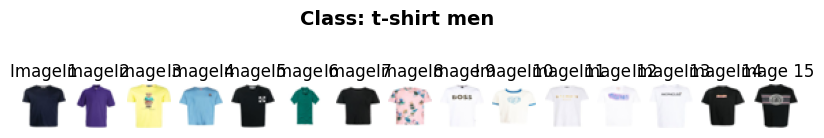

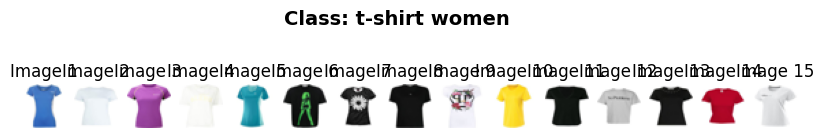

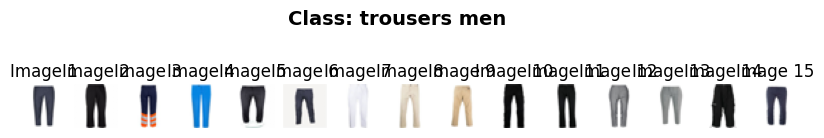

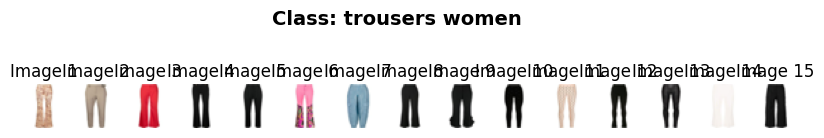

In [7]:
import os
import gdown
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors

# Set random seed for reproducibility
np.random.seed(42)

# Set TensorFlow random seed for reproducibility
tf.random.set_seed(42)

# Ссылка для скачивания архивного файла с датасетом
dataset_url = 'https://drive.google.com/uc?id=1ZdQ1dAGWOL8lTK73MQV1UQf-2S8BKcTq'

# Путь для сохранения архивного файла
zip_file_path = 'processed_extended_dataset.zip'

# Скачивание архивного файла
gdown.download(dataset_url, zip_file_path, quiet=False)

# Распаковка архивного файла
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Удаление архивного файла
os.remove(zip_file_path)

# Путь к распакованному датасету
dataset_path = 'dataset'

# Получение списка классов из директорий датасета
class_list = sorted(os.listdir(dataset_path))
num_classes = len(class_list)

# Создание пустых массивов для изображений и меток классов
image_array = []
data_labels = []

# Загрузка изображений и создание массива данных
for class_label, class_name in enumerate(class_list):
    class_dir = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_dir)
    num_images = len(image_files)

    for i in range(num_images):
        image_path = os.path.join(class_dir, image_files[i])
        try:
            image = Image.open(image_path).convert("RGB")
            image = image.resize((64, 64))
            image_array.append(np.array(image))
            data_labels.append(class_label)
        except Exception as e:
            print(f'Ошибка при обработке изображения {image_path}: {str(e)}')

image_array = np.array(image_array)
data_labels = np.array(data_labels)

# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(image_array, data_labels, test_size=0.2, stratify=data_labels, random_state=42)

# Преобразование меток классов в one-hot encoding
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

# Изменение размера обучающих и тестовых изображений на 32x32
x_train_resized = np.array([np.array(Image.fromarray(img).resize((32, 32))) for img in x_train])
x_test_resized = np.array([np.array(Image.fromarray(img).resize((32, 32))) for img in x_test])

# Преобразование значений пикселей в диапазон [0, 1]
x_train_resized = x_train_resized.astype('float32') / 255.
x_test_resized = x_test_resized.astype('float32') / 255.

# Encoder layers
input_img = Input(shape=(32, 32, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)
flat = Flatten()(pool3)
class_label = Input(shape=(num_classes,))
concat = concatenate([flat, class_label])
encoded = Dense(256, activation='relu')(concat)

# Decoder layers
x = Dense(128, activation='relu')(encoded)
x = Reshape((4, 4, 8))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = x

# Define the autoencoder model
autoencoder = Model([input_img, class_label], decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder model
history = autoencoder.fit([x_train_resized, y_train_cat], x_train_resized, epochs=10, batch_size=64, validation_data=([x_test_resized, y_test_cat], x_test_resized))

# Extract image embeddings using the trained encoder
encoder = Model([input_img, class_label], encoded)

# Изменение размера изображений на 32x32 для извлечения векторных представлений
resized_images = np.array([np.array(Image.fromarray(img).resize((32, 32))) for img in image_array])
image_embeddings = encoder.predict([resized_images, keras.utils.to_categorical(data_labels, num_classes)])

# Build and train the nearest neighbors model
neighbors_model = NearestNeighbors(n_neighbors=5, algorithm='auto')
neighbors_model.fit(image_embeddings)

# Plot training performance
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate reconstruction error as percentage
x_train_predicted = autoencoder.predict([x_train_resized, y_train_cat])
train_reconstruction_error = np.mean(np.abs(x_train_predicted - x_train_resized)) * 100

x_test_predicted = autoencoder.predict([x_test_resized, y_test_cat])
test_reconstruction_error = np.mean(np.abs(x_test_predicted - x_test_resized)) * 100

print(f'Training Reconstruction Error: {train_reconstruction_error:.2f}%')
print(f'Test Reconstruction Error: {test_reconstruction_error:.2f}%')

# Функция для вывода изображений по классам
def show_images_per_class(images, labels, class_list):
    num_classes = len(class_list)
    num_images_per_class = 15

    for class_label, class_name in enumerate(class_list):
        class_indices = np.where(labels == class_label)[0][:num_images_per_class]

        plt.figure(figsize=(10, 2))
        plt.suptitle(f'Class: {class_name}', fontsize=14, fontweight='bold')

        for i, idx in enumerate(class_indices):
            plt.subplot(1, num_images_per_class, i+1)
            plt.axis('off')
            plt.imshow(images[idx])
            plt.title(f'Image {i+1}')

    plt.show()

# Вывод изображений по классам для обучающего датасета
show_images_per_class(x_train_resized, y_train, class_list)

# Вывод изображений по классам для тестового датасета
show_images_per_class(x_test_resized, y_test, class_list)

